<a href="https://colab.research.google.com/github/Pro-Machina/LSTM-Covid-Predictions/blob/main/Kshitij_EPI_LSTM_Final_Code_14_Day_Lead.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade cython
!pip install --upgrade git+https://github.com/statsmodels/statsmodels

     |████████████████████████████████| 1.9 MB 5.0 MB/s 
  Attempting uninstall: cython
    Found existing installation: Cython 0.29.24
    Uninstalling Cython-0.29.24:
      Successfully uninstalled Cython-0.29.24
  Cloning https://github.com/statsmodels/statsmodels to /tmp/pip-req-build-r_qcwjec
  Running command git clone -q https://github.com/statsmodels/statsmodels /tmp/pip-req-build-r_qcwjec
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for statsmodels: filename=statsmodels-0.14.0.dev0+119.gab51acc4c-cp37-cp37m-linux_x86_64.whl size=17874817 sha256=1f6b6f1b7645ce183a233bf430a9e630d95f36369fb9db30e9e513d99d724f21
  Stored in directory: /tmp/pip-ephem-wheel-cache-iv1sn_53/wheels/a7/e2/12/87eac3fb9bcec178a4228e24f5d4c0996208883c6f1b44e941
Successfully built statsmodels
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10

In [ ]:
# Import packages
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import SequentialSampler
from torch import nn
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import statsmodels.api as sm
import scipy
import warnings
warnings.filterwarnings("ignore")
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def filter_states_df(df, state):
  """ Only keep rows in dataframe with geographic area of interest"""

  filtered_df = df[df['state'] == state]

  return filtered_df

###
def filter_dates_df(start_date, end_date, df):
  """ Extract the data corresponding to specific dates """

  if 'date' in df:
    filtered_data = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
  elif 'Date' in df:
    filtered_data = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

  return filtered_data

###
def filter_mobility_dates(start_date,end_date,df):
  """ Returning the rows that lie between start date and end date, both included """

  mobility_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

  return mobility_df

###
def get_mobility_state(df, state):
  """ Groups by region in mobility data and returns specific group """

  # print(df)
  df_group = df.groupby(by = ['region'])
  return df_group.get_group(state)

###
def split_mobility(df):
  """ Returns a list of DF, grouped as driving, transit and walking """

  df_split = df.groupby(by = ['transportation_type'])
  return [df_split.get_group('driving'), df_split.get_group('walking')]

###
def get_policy_state(df, state):

  df_group = df[(df['RegionName'] == state) & (df['CountryCode'] == 'USA')]
  return df_group

###
def get_desired_mobility(df):
  """ Manipulating mobility data frame to get specific mobility and specific date range """

  df = df.transpose()
  df = df.iloc[6:,:]
  df = df.reset_index()
  df.columns = ['Date', 'Mobility'] 
  df['Date'] = pd.to_datetime(df['Date']).dt.date
  df = filter_dates_df(datetime.date(2020, 3, 15), datetime.date(2021, 7, 2), df)

  return df

###
def standardize_df (df_input, target):
  """ Returns standardized data """

  df = df_input.copy()
  target_mean = df[target].mean()
  target_sd = df[target].std()

  for c in df.columns:
    mean = df[c].mean()
    sd = df[c].std()

    df[c] = (df[c] - mean)/sd
  
  df = df.fillna(0)

  return target_mean, target_sd, df

###
def scale_test_data(df_test_input, df_train_input):
  """ Standardizes the test data according to the training data """

  df_test = df_test_input.copy()
  df_train = df_train_input.copy()

  
  for c in df_test.columns:
    df_test[c] = (df_test[c] - df_train.mean(axis=0)[c])/df_train.std(axis=0)[c]

  df_test = df_test.fillna(0)
  return df_test

###
def LSTM_df (covid_df, driving_df, walking_df, policy_df, use_data = 'ALL'):
  """ Returns the data frame that can be used for LSTM input, use_data from 'ALL', 'C&D', 'MOB', 'POL' """

  reindex_df = np.linspace(1, int(covid_df.shape[0]), int(covid_df.shape[0]), dtype=int)

  covid_df = covid_df[['date', 'cases', 'deaths']]
  covid_df = covid_df.set_index('date')
  
  driving_df = driving_df[['Date', 'Mobility']]
  driving_df = driving_df.set_index('Date')
  walking_df = walking_df[['Date', 'Mobility']]
  walking_df = walking_df.set_index('Date')

  policy_df = policy_df[['Date', 'C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events', 'C4_Restrictions on gatherings', 'C5_Close public transport', 'C6_Stay at home requirements', 'C7_Restrictions on internal movement', 'C8_International travel controls', 'E1_Income support', 'E2_Debt/contract relief', 'E3_Fiscal measures', 'E4_International support', 'H1_Public information campaigns', 'H2_Testing policy', 'H3_Contact tracing', 'H4_Emergency investment in healthcare', 'H5_Investment in vaccines', 'H6_Facial Coverings', 'H7_Vaccination policy', 'H8_Protection of elderly people']]
  policy_df = policy_df.set_index('Date')

  if use_data == 'ALL':
    lstm_df = pd.concat([covid_df, driving_df, walking_df, policy_df], axis=1)
  elif use_data == 'C&D':
    lstm_df = covid_df
  elif use_data == 'MOB':
    lstm_df = pd.concat([covid_df, driving_df, walking_df], axis=1)
  elif use_data == 'POL':
    lstm_df = pd.concat([covid_df, policy_df], axis=1)

  return lstm_df

###
def train_test_data (df, start_date, end_date, factor=0.9):
  """ Splits the data into test and train according to the input factor """
  
  no_of_days = (end_date-start_date).days

  test_data_start_date = start_date + datetime.timedelta(days=int(no_of_days*factor))
  df_train = df.loc[:test_data_start_date].copy()
  df_test = df.loc[test_data_start_date:].copy()

  return df_train, df_test

###
def get_target_features(df_input, target_col, forecast_lead):
  """ Gets the target and features from the data frame """

  df = df_input.copy()
  features = list(df.columns.difference([target_col]))
  target = f"{target_col}_lead{forecast_lead}"
  df[target] = df[target_col].shift(-forecast_lead)
  df = df.iloc[:-forecast_lead]

  return target, features, df

In [ ]:
# Creating data-loader compatible dataset
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[i].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((x, padding), 0)

        return x, self.y[i]

# Creating data-loader compatible dataset
class SequenceDatasetTest(Dataset):
    def __init__(self, dataframe, df2, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.df2 = df2
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()
        self.X_train = torch.tensor(df2[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            start = self.sequence_length - i - 1
            padding = self.X_train[-start:]
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

# Creating LSTM model
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_features, hidden_units):
        super().__init__()
        self.num_features = num_features  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size = num_features,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers,
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)
        

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()

        return out

###
def train_model(data_loader, model, loss_function, optimizer):
  """ Funtion for training the model """

  num_batches = len(data_loader)
  total_loss = 0
  model.train()

  for X, y in data_loader:
      output = model(X)
      loss = loss_function(output, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

  avg_loss = total_loss / num_batches
  print(f"Train loss: {avg_loss}")

###
def test_model(data_loader, model, loss_function):
  """ Function for testing the model """

  num_batches = len(data_loader)
  total_loss = 0

  model.eval()
  with torch.no_grad():
      for X, y in data_loader:
        output = model(X)
        total_loss += loss_function(output, y).item()

  avg_loss = total_loss / num_batches
  print(f"Test loss: {avg_loss}")

###
def predict(data_loader, model):
  """ Uses model to predict """

  output = torch.tensor([])
  model.eval()
  with torch.no_grad():
      for X, _ in data_loader:
          y_star = model(X)
          output = torch.cat((output, y_star), 0)

  return output

In [ ]:
# Function that runs all the different LSTM models and ARIMA model for all regions
def mainProgram (covid_df, mobility_df, policy_df, region_list = ['Wyoming'], target_prediction = 'deaths', batch_size = 4, sequence_length = 500, lead = 14, learning_rate = 5e-5, num_hidden_units = 40, epochs = 100, ar_order = 14, ma_order = 0, d = 1):

  covid_df = covid_df.fillna(0)
  covid_df['date'] = pd.to_datetime(covid_df['date']).dt.date
  covid_df = covid_df.drop_duplicates(subset = ['date', 'state'], keep = 'last')
  covid_df = covid_df.drop(['fips'], axis=1)
  covid_df = filter_dates_df(datetime.date(2020, 3, 15), datetime.date(2021, 7, 2), covid_df)

  mobility_df = mobility_df.fillna(0)
  mobility_df = mobility_df[mobility_df['country'] == 'United States']
  mobility_df = mobility_df.fillna(method='ffill')
  mobility_driving_df, mobility_walking_df = split_mobility(mobility_df)

  policy_df = policy_df.fillna(0)
  policy_df['Date'] = pd.to_datetime(policy_df['Date'], format='%Y%m%d').dt.date
  policy_df = filter_dates_df(datetime.date(2020, 3, 15), datetime.date(2021, 7, 2), policy_df)

  mobility_driving_df, mobility_walking_df = split_mobility(mobility_df)

  output_LSTM_w_all = {}
  output_LSTM_w_mob = {}
  output_LSTM_w_pol = {}
  output_ARIMA = {}
  true_target = {}

  for city in region_list:
    
    ### Block 1
    city_covid_df = filter_states_df(covid_df, city)
    city_len = len(city_covid_df)
    city_driving_df = get_mobility_state(mobility_driving_df, city)
    city_driving_df = get_desired_mobility(city_driving_df)
    city_walking_df = get_mobility_state(mobility_walking_df, city)
    city_walking_df = get_desired_mobility(city_walking_df)

    city_policy_data = get_policy_state(policy_df, city)

    options = ['ALL', 'MOB', 'POL']
    # options = ['C&D']

    for use_data in options:

      city_lstm_df = LSTM_df(city_covid_df, city_driving_df, city_walking_df, city_policy_data, use_data)
      #
      city_target, city_features, city_lstm_df = get_target_features(city_lstm_df, target_prediction, forecast_lead=lead)
      split = 0.9
      city_train, city_test = train_test_data(city_lstm_df, datetime.date(2020, 3, 15), datetime.date(2021, 7, 2), split)
      city_target_mean, city_target_sd, city_train_scaled = standardize_df(city_train, city_target)
      city_test_scaled = scale_test_data(city_test, city_train)

      #
      torch.manual_seed(0)
      city_train_dataset = SequenceDataset(city_train_scaled, city_target, city_features, sequence_length)
      city_test_dataset = SequenceDatasetTest(city_test_scaled, city_train_scaled, city_target, city_features, sequence_length)
  
      city_train_loader = DataLoader(city_train_dataset, batch_size=batch_size)
      city_test_loader = DataLoader(city_test_dataset, batch_size=batch_size)
     
      ##
      X, y = next(iter(city_train_loader))
      model = ShallowRegressionLSTM(num_features = X.shape[2] , hidden_units=num_hidden_units)
      loss_function = nn.MSELoss()
      optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

      ##
      print("Untrained test\n--------")
      test_model(city_test_loader, model, loss_function)
      print()

      for e in range(epochs):
          print(f"Epoch {e+1}\n---------")
          train_model(city_train_loader, model, loss_function, optimizer=optimizer)
          test_model(city_test_loader, model, loss_function)
          print()

      city_train_eval_loader = DataLoader(city_train_dataset, batch_size=batch_size, shuffle=False)

      ystar_col = "Model forecast"

      city_train_scaled[ystar_col] = predict(city_train_eval_loader, model).numpy()
      city_test_scaled[ystar_col] = predict(city_test_loader, model).numpy()

      df_out = pd.concat((city_train_scaled, city_test_scaled))[[city_target, ystar_col]]

      for c in df_out.columns:
          df_out[c] = df_out[c] * city_target_sd + city_target_mean

      
      n = len(df_out['Model forecast'])
      y_pred_LSTM = list(df_out['Model forecast'][int(split*n):].values)
      print("Test RMSE for LSTM-", use_data, "for", city, '=', round(mean_squared_error(y_pred_LSTM,df_out[city_target][int(split*n):])**0.5, 3))
      print('\n')
      
      if use_data == 'ALL':
        output_LSTM_w_all[city] = y_pred_LSTM
      elif use_data == 'MOB':
        output_LSTM_w_mob[city] = y_pred_LSTM
      elif use_data == 'POL':
        output_LSTM_w_pol[city] = y_pred_LSTM

      #### ARIMA
      
    y_pred_arima = []

    new_df = city_covid_df.copy()
    # target_series is the cases/deaths for the particular state
    target_series = list(new_df[target_prediction].values)

    # splitting into history and test data
    history = list(target_series[:int(split*n)])
    test = list(target_series[int(split*n):])

    for i in range(len(test)):
      model = ARIMA(history, order=(lead,d,ma_order))
      model_fit = model.fit()
      yhat = model_fit.forecast()[0]
      y_pred_arima.append(yhat)
      history.append(yhat)

    rmse_arima_prev = (mean_squared_error(test, y_pred_arima))**0.5
    print("Test RMSE for ARIMA for ", city," = ", round(rmse_arima_prev,3))
    print("\n")
    
    output_ARIMA[city] = y_pred_arima

    true_target[city] = test
  
  return output_LSTM_w_all, output_LSTM_w_mob, output_LSTM_w_pol, output_ARIMA, true_target

In [ ]:
# Covid Cases and Deaths data
covid_df = pd.read_csv("/content/drive/MyDrive/CSE 8803 EPI/US States COVID NYT.csv")

# Mobility Data
mobility_df = pd.read_csv("/content/drive/MyDrive/CSE 8803 EPI/applemobilitytrends-2021-10-02.csv")

# Policy data
policy_df = pd.read_csv("/content/drive/MyDrive/CSE 8803 EPI/OxCGRT_latest.csv")

In [ ]:
#region_list = ['Wyoming', 'New Jersey', 'Montana', 'Vermont', 'Rhode Island']
# Run for lead = 7 and lead 14 and also for 'deaths' and 'cases'

region_list = ['Wyoming', 'New Jersey', 'Vermont']
output_LSTM_w_all, output_LSTM_w_mob, output_LSTM_w_pol, output_ARIMA, true_target = mainProgram (covid_df, mobility_df, policy_df, region_list, 'cases', batch_size = 4, sequence_length = 14, learning_rate = 5e-5, lead = 1, num_hidden_units = 40, epochs = 100)

Untrained test
--------
Test loss: 2.951952417691549

Epoch 1
---------
Train loss: 1.3063508803024888
Test loss: 2.754811783631643

Epoch 2
---------
Train loss: 1.1896432726992137
Test loss: 2.518016298611959

Epoch 3
---------
Train loss: 1.0846450848365639
Test loss: 2.3036656975746155

Epoch 4
---------
Train loss: 0.9853890281035695
Test loss: 2.1019902328650155

Epoch 5
---------
Train loss: 0.8884189793988018
Test loss: 1.9066820442676544

Epoch 6
---------
Train loss: 0.791247419993367
Test loss: 1.713424911101659

Epoch 7
---------
Train loss: 0.692607953448162
Test loss: 1.519543359676997

Epoch 8
---------
Train loss: 0.5927040960202342
Test loss: 1.323961188395818

Epoch 9
---------
Train loss: 0.49332818483594354
Test loss: 1.12722247838974

Epoch 10
---------
Train loss: 0.3975429914861256
Test loss: 0.9315309524536133

Epoch 11
---------
Train loss: 0.30892096917258105
Test loss: 0.7410436620314916

Epoch 12
---------
Train loss: 0.23078930597734926
Test loss: 0.5625830

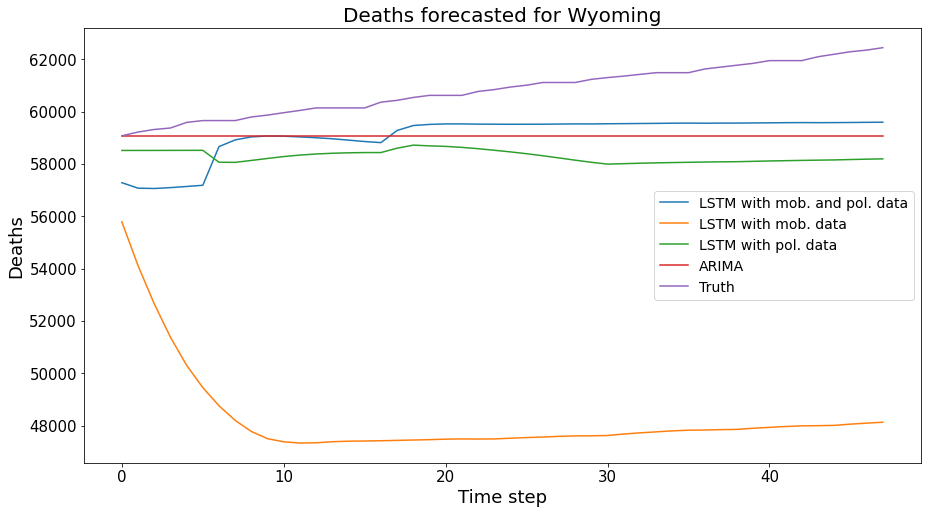

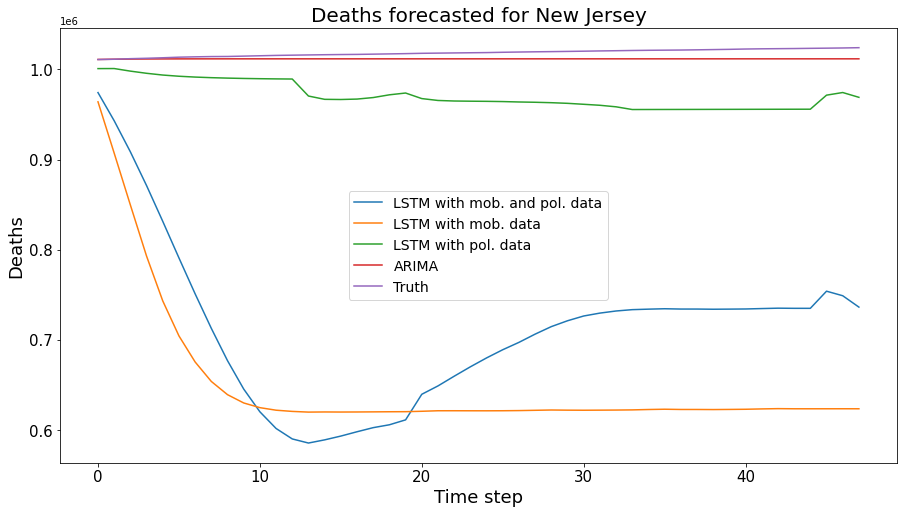

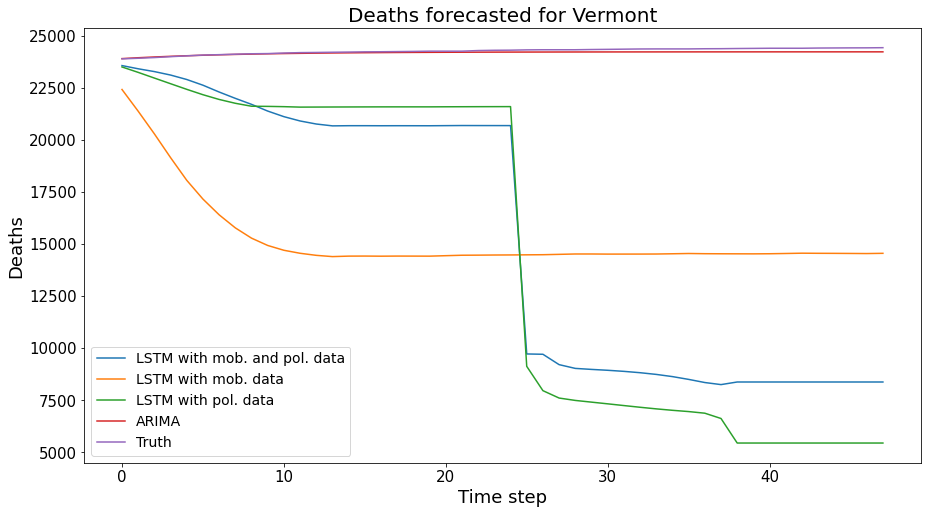

In [ ]:
# Plotting for all cities
for city in region_list:

  y_pred_LSTM_w_all = output_LSTM_w_all[city]
  y_pred_LSTM_w_mob = output_LSTM_w_mob[city]
  y_pred_LSTM_w_pol = output_LSTM_w_pol[city]
  y_pred_arima = output_ARIMA[city]
  test = true_target[city]

  plt.figure(figsize=(15,8))
  plt.title("Deaths forecasted for " + str(city), fontsize = 20)
  plt.xticks(fontsize=15)
  plt.yticks(fontsize=15)
  plt.xlabel("Time step", fontsize=18)
  plt.ylabel("Deaths", fontsize=18)

  plt.plot(range(len(y_pred_LSTM_w_all)), y_pred_LSTM_w_all)
  plt.plot(range(len(y_pred_LSTM_w_mob)), y_pred_LSTM_w_mob)
  plt.plot(range(len(y_pred_LSTM_w_pol)), y_pred_LSTM_w_pol)
  plt.plot(range(len(y_pred_arima)), y_pred_arima)
  plt.plot(range(len(test)), test)

  legend = ['LSTM with mob. and pol. data', 'LSTM with mob. data', 'LSTM with pol. data', 'ARIMA', 'Truth']
  plt.legend(legend, fontsize=14)
  plt.show()